In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm

import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
import torch.nn.functional as F

In [27]:
from torchvision.transforms import v2
torch.manual_seed(19)

transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(60),
    v2.ToDtype(torch.float32)
])


class NCaltech101ImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.transform = transform
        self.stage = 0

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        label_temp = np.zeros((101,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
    
    def set_stage(self, stage):
        self.stage = stage

In [28]:
training_data = NCaltech101ImageDataset("./Datasety/Ncaltech101", transform=transforms)

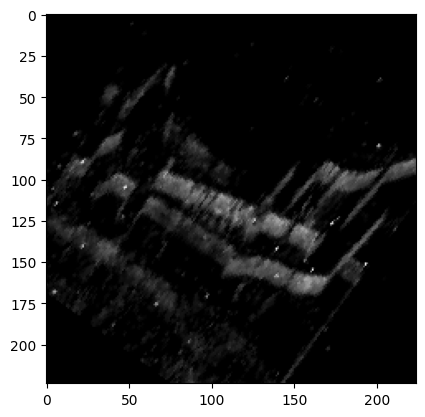

tensor(0.8586)


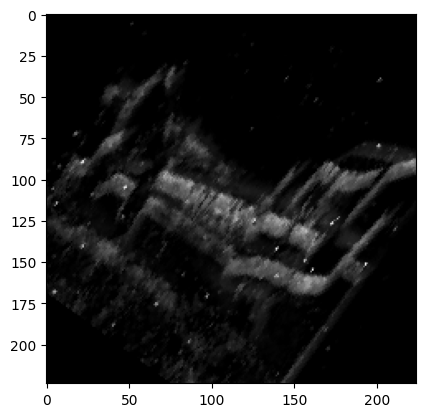

tensor(0.8586)


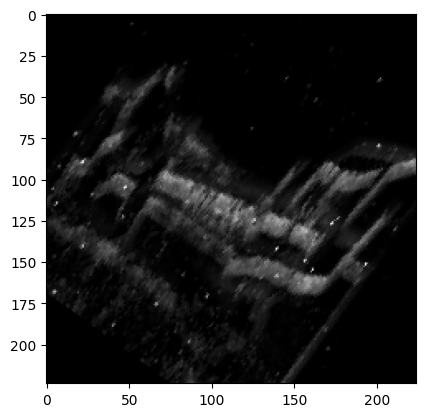

tensor(0.8587)


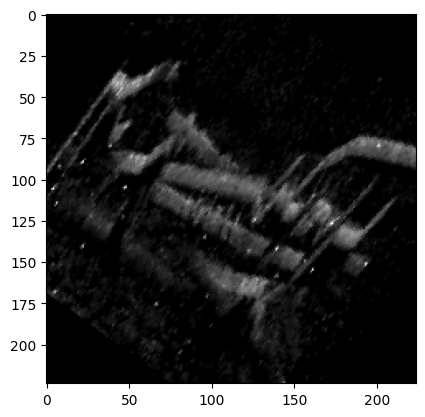

tensor(0.8586)


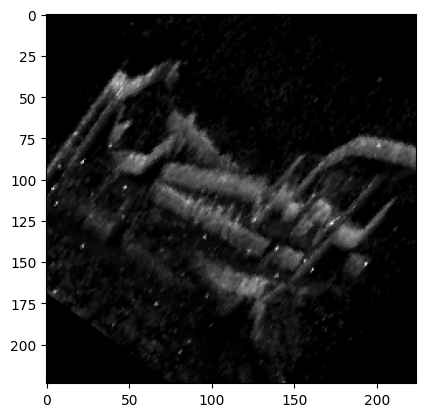

tensor(0.8587)


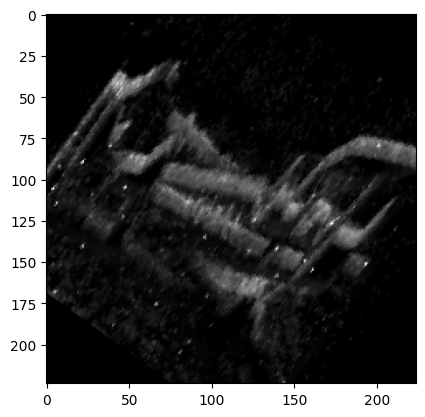

tensor(0.8588)


In [29]:
pic, label = training_data[100]

noBins = 3
for i in range(2*noBins):
    pic2 = pic[i,...]
    plt.gray()
    plt.imshow(pic2)
    plt.show()
    print(torch.max(pic2))

In [30]:
train_dataset, test_dataset = torch.utils.data.random_split(training_data, [0.8, 0.2])

In [31]:
from torch.utils.data import WeightedRandomSampler
train_dataset.dataset.set_stage(1)
class_sample_count = np.zeros(101)
for i in range(len(train_dataset)):
    img, label = train_dataset[i]
    class_sample_count[np.argmax(label)] += 1

weight = 1. / class_sample_count
samples_weight = np.array([weight[int(np.argmax(train_dataset[t][1]))] for t in range(len(train_dataset))])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

In [32]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [33]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.hardtanh(out, inplace=False, min_val=-1.0, max_val=1.0)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_channels = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.hardtanh(x,min_val=-2, max_val=2)
        x = self.dropout(x)
        x = self.fc2(x)
        return x# F.hardtanh(x)
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs

            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))


            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet_nCars_Hardtanh_ReLUmaxpool_EST__FC2.pt")

                print('Accuracy of the network: {} Loss: {}%'.format( 100 * correct / total, val_loss/len(valid_loader)))


# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
#         super(ResidualBlock, self).__init__()
#         if(downsample is not None):
#             self.conv1 = nn.Sequential(
#                             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
#                             nn.BatchNorm2d(out_channels),
#                             nn.ReLU(inplace=False),
#                             nn.MaxPool2d(kernel_size=2, stride=2)
#                             )  # Changed inplace to False
#         else:
#             self.conv1 = nn.Sequential(
#                             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
#                             nn.BatchNorm2d(out_channels),
#                             nn.ReLU( inplace=False)
#                             )
#         self.conv2 = nn.Sequential(
#                         nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
#                         nn.BatchNorm2d(out_channels),
#                         nn.ReLU( inplace=False))  # Changed inplace to False
#         self.downsample = downsample
#         self.relu = nn.ReLU( inplace=False)  # Changed inplace to False
#         self.out_channels = out_channels
#         self.end_maxpool = end_maxpool

#     def forward(self, x):
#         residual = x
#         out = self.conv1(x)
#         out = self.conv2(out)
#         if self.downsample:
#             residual = self.downsample(x)
#         out = out + residual
#         if self.end_maxpool:
#             out = F.relu(out, inplace=False)
#         else:
#             out = F.hardtanh(out, inplace=False, min_val=-1.0, max_val=1.0)   # Use non-in-place ReLU
#         return out

# class ResNet(nn.Module):
#     def __init__(self, block, layers, num_classes = 2, in_channels = 5):
#         super(ResNet, self).__init__()
#         self.inplanes = 64
#         self.conv1 = nn.Sequential(
#                         nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 2, padding = 3),
#                         nn.BatchNorm2d(64),
#                         nn.ReLU(inplace=False))
#         self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
#         self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
#         self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
#         self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
#         self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
#         self.avgpool = nn.MaxPool2d(7, stride=1)
#         self.fc = nn.Linear(512, 256)
#         self.fc2 = nn.Linear(256, num_classes)
#         self.dropout = nn.Dropout(0.2)

#     def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
#         downsample = None
#         if stride != 1 or self.inplanes != planes:

#             downsample = nn.Sequential(
#                 nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
#                 nn.BatchNorm2d(planes),
#                 nn.ReLU(inplace=False),
#                 nn.MaxPool2d(kernel_size=2, stride=2)
#             )
#         layers = []
#         layers.append(block(self.inplanes, planes, stride, downsample))
#         self.inplanes = planes
#         for i in range(1, blocks):
#             if i == blocks-1 and end_maxpool:
#                 layers.append(block(self.inplanes, planes, end_maxpool = True))
#             else:
#                 layers.append(block(self.inplanes, planes))

#         return nn.Sequential(*layers)
    
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.maxpool(x)
#         x = self.layer0(x)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         x = F.hardtanh(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x# F.hardtanh(x)
    
#     def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
#         best_accuracy = 0.0
#         total_step = len(train_loader)
#         # Loss and optimizer
#         criterion = nn.CrossEntropyLoss()
#         optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

#         for epoch in range(num_epochs):
#             # self.train()
#             correct = 0
#             total = 0
#             running_loss = 0.0
#             train_loader.dataset.dataset.set_stage(0)
#             for i, (images, labels) in enumerate(tqdm(train_loader)):
#                 # Move tensors to the configured device
#                 images = images.float().to("cuda")
#                 labels = labels.type(torch.FloatTensor)
#                 labels = labels.to("cuda")


#                 optimizer.zero_grad()

#                 # Forward pass
#                 outputs = self.forward(images)
#                 loss = criterion(outputs, labels)
#                 # Backward and optimize
#                 loss.backward()
                
#                 optimizer.step()

#                 # accuracy
#                 _, predicted = torch.max(outputs.data, 1)
#                 correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
#                 total += labels.size(0)
#                 running_loss += loss.item()
#                 del images, labels, outputs

#             print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
#                             .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))


#             if torch.cuda.is_available():
#                 torch.cuda.empty_cache()

#             # Validation
#             with torch.no_grad():
#                 correct = 0
#                 total = 0
#                 val_loss = 0.0
#                 valid_loader.dataset.dataset.set_stage(1)
#                 for images, labels in valid_loader:
#                     images = images.float().to("cuda")
#                     labels = labels.type(torch.FloatTensor)
#                     labels = labels.to("cuda")
#                     outputs = self.forward(images)
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
#                     loss = criterion(outputs, labels)
#                     val_loss += loss.item()
#                     del images, labels, outputs
#                 if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
#                     torch.save(self.state_dict(), "best_resnet_nCars_Hardtanh_ReLUmaxpool_EST__FC2.pt")

#                 print('Accuracy of the network: {} Loss: {}%'.format( 100 * correct / total, val_loss/len(valid_loader)))

In [34]:
model_resnet = ResNet(ResidualBlock, [5, 6, 6, 4], in_channels = 6, num_classes=101).to("cuda")

In [35]:
model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=10)

100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [1/10], Step [109/109], Loss: 8.0519, Accuracy: 0.0115
Accuracy of the network: 3.2165422171166 Loss: 4.566585367376154%


 23%|██▎       | 25/109 [00:14<00:48,  1.72it/s]


KeyboardInterrupt: 

In [ ]:
model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=100,learning_rate=1e-4)

100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [1/100], Step [109/109], Loss: 4.3211, Accuracy: 0.0319
Accuracy of the network: 3.331418724870764 Loss: 4.3050107435746625%


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [2/100], Step [109/109], Loss: 4.2384, Accuracy: 0.0418
Accuracy of the network: 6.4330844342332 Loss: 4.241946627876976%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [3/100], Step [109/109], Loss: 4.1751, Accuracy: 0.0465
Accuracy of the network: 8.788052843193567 Loss: 4.114329615506259%


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [4/100], Step [109/109], Loss: 4.0914, Accuracy: 0.0531
Accuracy of the network: 10.683515221137277 Loss: 4.035427943142977%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [5/100], Step [109/109], Loss: 4.0141, Accuracy: 0.0733
Accuracy of the network: 10.51120045950603 Loss: 3.988525980169123%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [6/100], Step [109/109], Loss: 3.9216, Accuracy: 0.0874
Accuracy of the network: 12.11947156806433 Loss: 3.937138791517778%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [7/100], Step [109/109], Loss: 3.8736, Accuracy: 0.0941
Accuracy of the network: 13.785180930499713 Loss: 3.8067550225691362%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [8/100], Step [109/109], Loss: 3.7832, Accuracy: 0.1118
Accuracy of the network: 15.910396323951751 Loss: 3.6064499551599676%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [9/100], Step [109/109], Loss: 3.7133, Accuracy: 0.1142
Accuracy of the network: 13.785180930499713 Loss: 3.7577890396118163%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [10/100], Step [109/109], Loss: 3.6510, Accuracy: 0.1213
Accuracy of the network: 15.04882251579552 Loss: 3.5374163714322178%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [11/100], Step [109/109], Loss: 3.5807, Accuracy: 0.1379
Accuracy of the network: 15.336013785180931 Loss: 3.4855272379788484%


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [12/100], Step [109/109], Loss: 3.5392, Accuracy: 0.1396
Accuracy of the network: 21.42446869615164 Loss: 3.364514229514382%


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [13/100], Step [109/109], Loss: 3.4917, Accuracy: 0.1494
Accuracy of the network: 17.863296955772544 Loss: 3.4461386767300692%


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [14/100], Step [109/109], Loss: 3.4883, Accuracy: 0.1507
Accuracy of the network: 17.346352670878805 Loss: 3.4287852373990146%


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [15/100], Step [109/109], Loss: 3.3803, Accuracy: 0.1708
Accuracy of the network: 22.113727742676623 Loss: 3.2947708086533978%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [16/100], Step [109/109], Loss: 3.3145, Accuracy: 0.1879
Accuracy of the network: 22.113727742676623 Loss: 3.210835838317871%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [17/100], Step [109/109], Loss: 3.2536, Accuracy: 0.1989
Accuracy of the network: 21.42446869615164 Loss: 3.2591704325242477%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [18/100], Step [109/109], Loss: 3.2098, Accuracy: 0.2113
Accuracy of the network: 20.50545663411832 Loss: 3.2758202119307085%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [19/100], Step [109/109], Loss: 3.1078, Accuracy: 0.2272
Accuracy of the network: 24.124066628374496 Loss: 3.1503450133583764%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [20/100], Step [109/109], Loss: 3.0397, Accuracy: 0.2431
Accuracy of the network: 24.46869615163699 Loss: 3.0537418062036688%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [21/100], Step [109/109], Loss: 3.0279, Accuracy: 0.2510
Accuracy of the network: 25.330269959793224 Loss: 3.077155035192316%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [22/100], Step [109/109], Loss: 2.9626, Accuracy: 0.2714
Accuracy of the network: 29.75301550832855 Loss: 2.916617285121571%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [23/100], Step [109/109], Loss: 2.8899, Accuracy: 0.2760
Accuracy of the network: 29.982768523836874 Loss: 2.9484166448766533%


100%|██████████| 109/109 [01:05<00:00,  1.68it/s]


Epoch [24/100], Step [109/109], Loss: 2.8782, Accuracy: 0.2859
Accuracy of the network: 33.48650201033889 Loss: 2.7838535872372714%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [25/100], Step [109/109], Loss: 2.8043, Accuracy: 0.2928
Accuracy of the network: 32.56748994830557 Loss: 2.819374912435358%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [26/100], Step [109/109], Loss: 2.7718, Accuracy: 0.3025
Accuracy of the network: 27.340608845491097 Loss: 2.988504825938832%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [27/100], Step [109/109], Loss: 2.7207, Accuracy: 0.3113
Accuracy of the network: 34.80758184951178 Loss: 2.7279390941966666%


100%|██████████| 109/109 [01:05<00:00,  1.68it/s]


Epoch [28/100], Step [109/109], Loss: 2.7007, Accuracy: 0.3173
Accuracy of the network: 36.58816771970132 Loss: 2.6370399951934815%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [29/100], Step [109/109], Loss: 2.6710, Accuracy: 0.3232
Accuracy of the network: 32.96955772544515 Loss: 2.7430467995730314%


100%|██████████| 109/109 [01:05<00:00,  1.68it/s]


Epoch [30/100], Step [109/109], Loss: 2.6032, Accuracy: 0.3441
Accuracy of the network: 38.48363009764503 Loss: 2.5594602931629526%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [31/100], Step [109/109], Loss: 2.5914, Accuracy: 0.3447
Accuracy of the network: 31.648477886272257 Loss: 2.8048141609538684%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [32/100], Step [109/109], Loss: 2.5850, Accuracy: 0.3444
Accuracy of the network: 37.564618035611716 Loss: 2.5856755646792324%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [33/100], Step [109/109], Loss: 2.5384, Accuracy: 0.3483
Accuracy of the network: 36.30097645031591 Loss: 2.6101078640330924%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [34/100], Step [109/109], Loss: 2.4842, Accuracy: 0.3642
Accuracy of the network: 33.08443423319931 Loss: 2.6726031888615003%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [35/100], Step [109/109], Loss: 2.4758, Accuracy: 0.3635
Accuracy of the network: 32.165422171166 Loss: 2.8052338990298185%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [36/100], Step [109/109], Loss: 2.4474, Accuracy: 0.3708
Accuracy of the network: 39.402642159678344 Loss: 2.5354591673070734%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [37/100], Step [109/109], Loss: 2.4375, Accuracy: 0.3684
Accuracy of the network: 36.58816771970132 Loss: 2.5747687816619873%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [38/100], Step [109/109], Loss: 2.3829, Accuracy: 0.3856
Accuracy of the network: 40.72372199885123 Loss: 2.4468687664378774%


100%|██████████| 109/109 [01:05<00:00,  1.68it/s]


Epoch [39/100], Step [109/109], Loss: 2.3723, Accuracy: 0.3919
Accuracy of the network: 38.94313612866169 Loss: 2.5084967634894633%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [40/100], Step [109/109], Loss: 2.3235, Accuracy: 0.3990
Accuracy of the network: 37.10511200459506 Loss: 2.5134520595723933%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [41/100], Step [109/109], Loss: 2.3183, Accuracy: 0.3941
Accuracy of the network: 39.115450890292934 Loss: 2.5145129312168466%


100%|██████████| 109/109 [01:06<00:00,  1.65it/s]


Epoch [42/100], Step [109/109], Loss: 2.3171, Accuracy: 0.3958
Accuracy of the network: 41.98736358414704 Loss: 2.3665052847428756%


100%|██████████| 109/109 [01:06<00:00,  1.65it/s]


Epoch [43/100], Step [109/109], Loss: 2.2479, Accuracy: 0.4186
Accuracy of the network: 39.00057438253877 Loss: 2.4608280008489434%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [44/100], Step [109/109], Loss: 2.2338, Accuracy: 0.4168
Accuracy of the network: 40.32165422171166 Loss: 2.4084565661170267%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [45/100], Step [109/109], Loss: 2.2243, Accuracy: 0.4226
Accuracy of the network: 41.98736358414704 Loss: 2.3024906028400767%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [46/100], Step [109/109], Loss: 2.2160, Accuracy: 0.4179
Accuracy of the network: 42.33199310740954 Loss: 2.3091391411694615%


100%|██████████| 109/109 [01:06<00:00,  1.65it/s]


Epoch [47/100], Step [109/109], Loss: 2.1644, Accuracy: 0.4331
Accuracy of the network: 42.38943136128662 Loss: 2.370187997817993%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [48/100], Step [109/109], Loss: 2.1527, Accuracy: 0.4360
Accuracy of the network: 43.99770246984492 Loss: 2.286094424941323%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [49/100], Step [109/109], Loss: 2.1642, Accuracy: 0.4347
Accuracy of the network: 44.85927627800115 Loss: 2.3069769577546553%


100%|██████████| 109/109 [01:05<00:00,  1.68it/s]


Epoch [50/100], Step [109/109], Loss: 2.1460, Accuracy: 0.4354
Accuracy of the network: 42.61918437679495 Loss: 2.3172717116095805%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [51/100], Step [109/109], Loss: 2.1289, Accuracy: 0.4377
Accuracy of the network: 40.26421596783458 Loss: 2.3657927664843474%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [52/100], Step [109/109], Loss: 2.0931, Accuracy: 0.4475
Accuracy of the network: 43.30844342331993 Loss: 2.3065629785711117%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [53/100], Step [109/109], Loss: 2.0536, Accuracy: 0.4580
Accuracy of the network: 43.19356691556577 Loss: 2.273639306155118%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [54/100], Step [109/109], Loss: 2.0372, Accuracy: 0.4638
Accuracy of the network: 43.59563469270534 Loss: 2.286720230362632%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [55/100], Step [109/109], Loss: 2.0090, Accuracy: 0.4677
Accuracy of the network: 45.548535324526135 Loss: 2.224431876702742%


100%|██████████| 109/109 [01:06<00:00,  1.65it/s]


Epoch [56/100], Step [109/109], Loss: 2.0239, Accuracy: 0.4598
Accuracy of the network: 44.11257897759908 Loss: 2.254217254031788%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [57/100], Step [109/109], Loss: 1.9829, Accuracy: 0.4805
Accuracy of the network: 44.170017231476166 Loss: 2.2180395234714854%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [58/100], Step [109/109], Loss: 1.9183, Accuracy: 0.5004
Accuracy of the network: 44.170017231476166 Loss: 2.2375941970131614%


100%|██████████| 109/109 [01:06<00:00,  1.63it/s]


Epoch [59/100], Step [109/109], Loss: 1.9430, Accuracy: 0.4813
Accuracy of the network: 46.352670878805284 Loss: 2.1632749384099785%


100%|██████████| 109/109 [01:07<00:00,  1.61it/s]


Epoch [60/100], Step [109/109], Loss: 1.9421, Accuracy: 0.4958
Accuracy of the network: 42.50430786904078 Loss: 2.319248828020963%


100%|██████████| 109/109 [01:06<00:00,  1.63it/s]


Epoch [61/100], Step [109/109], Loss: 1.9282, Accuracy: 0.4862
Accuracy of the network: 46.295232624928204 Loss: 2.152633467587558%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [62/100], Step [109/109], Loss: 1.8857, Accuracy: 0.5062
Accuracy of the network: 44.85927627800115 Loss: 2.164739155769348%


100%|██████████| 109/109 [01:06<00:00,  1.65it/s]


Epoch [63/100], Step [109/109], Loss: 1.9210, Accuracy: 0.4925
Accuracy of the network: 46.81217690982194 Loss: 2.117289590835571%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [64/100], Step [109/109], Loss: 1.8836, Accuracy: 0.5014
Accuracy of the network: 45.893164847788626 Loss: 2.1575008153915407%


100%|██████████| 109/109 [01:03<00:00,  1.72it/s]


Epoch [65/100], Step [109/109], Loss: 1.8811, Accuracy: 0.5042
Accuracy of the network: 45.376220562894886 Loss: 2.141382516514171%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [66/100], Step [109/109], Loss: 1.8521, Accuracy: 0.5079
Accuracy of the network: 44.62952326249282 Loss: 2.1586130705746736%


100%|██████████| 109/109 [01:03<00:00,  1.72it/s]


Epoch [67/100], Step [109/109], Loss: 1.8662, Accuracy: 0.5030
Accuracy of the network: 43.59563469270534 Loss: 2.28143788467754%


100%|██████████| 109/109 [01:03<00:00,  1.70it/s]


Epoch [68/100], Step [109/109], Loss: 1.8300, Accuracy: 0.5136
Accuracy of the network: 48.59276278001149 Loss: 2.070877881483598%


100%|██████████| 109/109 [01:03<00:00,  1.70it/s]


Epoch [69/100], Step [109/109], Loss: 1.7997, Accuracy: 0.5152
Accuracy of the network: 49.68408960367605 Loss: 2.0912892233241687%


100%|██████████| 109/109 [01:04<00:00,  1.70it/s]


Epoch [70/100], Step [109/109], Loss: 1.8433, Accuracy: 0.5121
Accuracy of the network: 45.548535324526135 Loss: 2.1543979493054475%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [71/100], Step [109/109], Loss: 1.8245, Accuracy: 0.5199
Accuracy of the network: 46.639862148190694 Loss: 2.1364218386736784%


100%|██████████| 109/109 [01:03<00:00,  1.72it/s]


Epoch [72/100], Step [109/109], Loss: 1.7791, Accuracy: 0.5277
Accuracy of the network: 48.42044801838024 Loss: 2.10686638138511%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [73/100], Step [109/109], Loss: 1.7725, Accuracy: 0.5290
Accuracy of the network: 50.14359563469271 Loss: 2.0292025674473155%


100%|██████████| 109/109 [01:04<00:00,  1.70it/s]


Epoch [74/100], Step [109/109], Loss: 1.7753, Accuracy: 0.5293
Accuracy of the network: 49.56921309592188 Loss: 2.0409688602794303%


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [75/100], Step [109/109], Loss: 1.7860, Accuracy: 0.5231
Accuracy of the network: 49.5117748420448 Loss: 2.0754561142487957%


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [76/100], Step [109/109], Loss: 1.7471, Accuracy: 0.5311
Accuracy of the network: 47.67375071797817 Loss: 2.061797430298545%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [77/100], Step [109/109], Loss: 1.7197, Accuracy: 0.5415
Accuracy of the network: 45.605973578403216 Loss: 2.218991353295066%


100%|██████████| 109/109 [01:07<00:00,  1.62it/s]


Epoch [78/100], Step [109/109], Loss: 1.7340, Accuracy: 0.5350
Accuracy of the network: 48.01838024124066 Loss: 2.092000803080472%


100%|██████████| 109/109 [01:07<00:00,  1.62it/s]


Epoch [79/100], Step [109/109], Loss: 1.6907, Accuracy: 0.5508
Accuracy of the network: 46.984491671453185 Loss: 2.176210631023754%


100%|██████████| 109/109 [01:06<00:00,  1.63it/s]


Epoch [80/100], Step [109/109], Loss: 1.7077, Accuracy: 0.5466
Accuracy of the network: 48.07581849511775 Loss: 2.115366467562589%


100%|██████████| 109/109 [01:05<00:00,  1.65it/s]


Epoch [81/100], Step [109/109], Loss: 1.7208, Accuracy: 0.5485
Accuracy of the network: 48.99483055715106 Loss: 2.1415536988865247%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [82/100], Step [109/109], Loss: 1.6825, Accuracy: 0.5514
Accuracy of the network: 43.76794945433659 Loss: 2.23918559551239%


100%|██████████| 109/109 [01:06<00:00,  1.63it/s]


Epoch [83/100], Step [109/109], Loss: 1.6983, Accuracy: 0.5466
Accuracy of the network: 49.91384261918438 Loss: 2.0116001866080544%


100%|██████████| 109/109 [01:07<00:00,  1.63it/s]


Epoch [84/100], Step [109/109], Loss: 1.7025, Accuracy: 0.5491
Accuracy of the network: 45.950603101665706 Loss: 2.1334706783294677%


100%|██████████| 109/109 [01:08<00:00,  1.59it/s]


Epoch [85/100], Step [109/109], Loss: 1.7163, Accuracy: 0.5452
Accuracy of the network: 48.19069500287191 Loss: 2.050384939800609%


100%|██████████| 109/109 [01:07<00:00,  1.61it/s]


Epoch [86/100], Step [109/109], Loss: 1.6497, Accuracy: 0.5550
Accuracy of the network: 48.36300976450316 Loss: 2.070607317577709%


100%|██████████| 109/109 [01:07<00:00,  1.61it/s]


Epoch [87/100], Step [109/109], Loss: 1.6576, Accuracy: 0.5607
Accuracy of the network: 48.19069500287191 Loss: 2.0791389487006446%


100%|██████████| 109/109 [01:07<00:00,  1.62it/s]


Epoch [88/100], Step [109/109], Loss: 1.6799, Accuracy: 0.5522
Accuracy of the network: 50.08615738081562 Loss: 2.0527407364411787%


100%|██████████| 109/109 [01:07<00:00,  1.61it/s]


Epoch [89/100], Step [109/109], Loss: 1.6175, Accuracy: 0.5745
Accuracy of the network: 50.89029293509477 Loss: 1.9453253052451394%


100%|██████████| 109/109 [01:07<00:00,  1.61it/s]


Epoch [90/100], Step [109/109], Loss: 1.6425, Accuracy: 0.5568
Accuracy of the network: 47.09936817920735 Loss: 2.056162457032637%


100%|██████████| 109/109 [01:08<00:00,  1.59it/s]


Epoch [91/100], Step [109/109], Loss: 1.6505, Accuracy: 0.5580
Accuracy of the network: 49.22458357265939 Loss: 2.0333343700929123%


100%|██████████| 109/109 [01:08<00:00,  1.59it/s]


Epoch [92/100], Step [109/109], Loss: 1.5854, Accuracy: 0.5753
Accuracy of the network: 49.56921309592188 Loss: 2.042539358139038%


100%|██████████| 109/109 [01:08<00:00,  1.59it/s]


Epoch [93/100], Step [109/109], Loss: 1.6211, Accuracy: 0.5653
Accuracy of the network: 48.13325674899483 Loss: 2.0578575957905163%


100%|██████████| 109/109 [01:08<00:00,  1.59it/s]


Epoch [94/100], Step [109/109], Loss: 1.5684, Accuracy: 0.5762
Accuracy of the network: 47.214244686961514 Loss: 2.15567684173584%


100%|██████████| 109/109 [01:08<00:00,  1.59it/s]


Epoch [95/100], Step [109/109], Loss: 1.6152, Accuracy: 0.5646
Accuracy of the network: 47.84606547960942 Loss: 2.062843656539917%


100%|██████████| 109/109 [01:08<00:00,  1.59it/s]


Epoch [96/100], Step [109/109], Loss: 1.5918, Accuracy: 0.5728
Accuracy of the network: 48.70763928776565 Loss: 2.0759553345766935%


100%|██████████| 109/109 [01:08<00:00,  1.59it/s]


Epoch [97/100], Step [109/109], Loss: 1.5995, Accuracy: 0.5663
Accuracy of the network: 49.56921309592188 Loss: 2.0079976125196977%


100%|██████████| 109/109 [01:08<00:00,  1.59it/s]


Epoch [98/100], Step [109/109], Loss: 1.5606, Accuracy: 0.5831
Accuracy of the network: 45.203905801263645 Loss: 2.1088624845851554%


100%|██████████| 109/109 [01:08<00:00,  1.60it/s]


Epoch [99/100], Step [109/109], Loss: 1.5536, Accuracy: 0.5815
Accuracy of the network: 49.85640436530729 Loss: 2.0353131662715565%


100%|██████████| 109/109 [01:08<00:00,  1.60it/s]


Epoch [100/100], Step [109/109], Loss: 1.5358, Accuracy: 0.5934
Accuracy of the network: 49.33946008041355 Loss: 2.0828546328978104%


In [ ]:
model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=100,learning_rate=3e-5)

100%|██████████| 109/109 [01:07<00:00,  1.62it/s]


Epoch [1/100], Step [109/109], Loss: 1.4872, Accuracy: 0.6072
Accuracy of the network: 49.05226881102814 Loss: 2.009264414960688%


100%|██████████| 109/109 [01:07<00:00,  1.61it/s]


Epoch [2/100], Step [109/109], Loss: 1.3852, Accuracy: 0.6442
Accuracy of the network: 54.623779437105114 Loss: 1.8417969898744062%


100%|██████████| 109/109 [01:08<00:00,  1.60it/s]


Epoch [3/100], Step [109/109], Loss: 1.3513, Accuracy: 0.6411
Accuracy of the network: 54.049396898334294 Loss: 1.8979759736494584%


100%|██████████| 109/109 [01:07<00:00,  1.61it/s]


Epoch [4/100], Step [109/109], Loss: 1.2981, Accuracy: 0.6580
Accuracy of the network: 55.255600229753014 Loss: 1.8563224640759555%


100%|██████████| 109/109 [01:08<00:00,  1.60it/s]


Epoch [5/100], Step [109/109], Loss: 1.3100, Accuracy: 0.6534
Accuracy of the network: 53.532452613440555 Loss: 1.8546408479863947%


100%|██████████| 109/109 [01:08<00:00,  1.60it/s]


Epoch [6/100], Step [109/109], Loss: 1.2788, Accuracy: 0.6659
Accuracy of the network: 53.991958644457206 Loss: 1.8404236229983244%


100%|██████████| 109/109 [01:07<00:00,  1.61it/s]


Epoch [7/100], Step [109/109], Loss: 1.2807, Accuracy: 0.6566
Accuracy of the network: 53.015508328546815 Loss: 1.8900655031204223%


100%|██████████| 109/109 [01:07<00:00,  1.60it/s]


Epoch [8/100], Step [109/109], Loss: 1.2372, Accuracy: 0.6821
Accuracy of the network: 53.76220562894888 Loss: 1.8362056515433571%


100%|██████████| 109/109 [01:08<00:00,  1.59it/s]


Epoch [9/100], Step [109/109], Loss: 1.2163, Accuracy: 0.6741
Accuracy of the network: 51.06260769672602 Loss: 1.9199571176008745%


100%|██████████| 109/109 [01:08<00:00,  1.59it/s]


Epoch [10/100], Step [109/109], Loss: 1.2340, Accuracy: 0.6686
Accuracy of the network: 53.647329121194716 Loss: 1.880493077364835%


100%|██████████| 109/109 [01:08<00:00,  1.59it/s]


Epoch [11/100], Step [109/109], Loss: 1.2183, Accuracy: 0.6821
Accuracy of the network: 55.025847214244685 Loss: 1.8493602059104226%


100%|██████████| 109/109 [01:08<00:00,  1.59it/s]


Epoch [12/100], Step [109/109], Loss: 1.2661, Accuracy: 0.6625
Accuracy of the network: 54.623779437105114 Loss: 1.825358468836004%


100%|██████████| 109/109 [01:06<00:00,  1.63it/s]


Epoch [13/100], Step [109/109], Loss: 1.2184, Accuracy: 0.6701
Accuracy of the network: 53.589890867317635 Loss: 1.8424438910050827%


100%|██████████| 109/109 [01:06<00:00,  1.65it/s]


Epoch [14/100], Step [109/109], Loss: 1.2148, Accuracy: 0.6803
Accuracy of the network: 53.819643882825964 Loss: 1.8834865374998613%


100%|██████████| 109/109 [01:06<00:00,  1.65it/s]


Epoch [15/100], Step [109/109], Loss: 1.1906, Accuracy: 0.6823
Accuracy of the network: 52.38368753589891 Loss: 1.9266911008141256%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [16/100], Step [109/109], Loss: 1.1793, Accuracy: 0.6930
Accuracy of the network: 54.681217690982194 Loss: 1.859057610685175%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [17/100], Step [109/109], Loss: 1.1746, Accuracy: 0.6825
Accuracy of the network: 54.336588167719704 Loss: 1.8452369213104247%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [18/100], Step [109/109], Loss: 1.1855, Accuracy: 0.6902
Accuracy of the network: 55.255600229753014 Loss: 1.8849687402898616%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [19/100], Step [109/109], Loss: 1.1507, Accuracy: 0.6965
Accuracy of the network: 52.498564043653076 Loss: 1.884925627708435%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [20/100], Step [109/109], Loss: 1.1734, Accuracy: 0.6883
Accuracy of the network: 55.255600229753014 Loss: 1.814583917097612%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [21/100], Step [109/109], Loss: 1.1265, Accuracy: 0.6999
Accuracy of the network: 53.647329121194716 Loss: 1.881684136390686%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [22/100], Step [109/109], Loss: 1.1681, Accuracy: 0.6914
Accuracy of the network: 53.934520390580126 Loss: 1.856909814747897%


100%|██████████| 109/109 [01:06<00:00,  1.65it/s]


Epoch [23/100], Step [109/109], Loss: 1.1186, Accuracy: 0.7018
Accuracy of the network: 55.14072372199885 Loss: 1.8273299022154375%


100%|██████████| 109/109 [01:03<00:00,  1.72it/s]


Epoch [24/100], Step [109/109], Loss: 1.1282, Accuracy: 0.7036
Accuracy of the network: 53.302699597932225 Loss: 1.8822040471163664%


100%|██████████| 109/109 [01:03<00:00,  1.73it/s]


Epoch [25/100], Step [109/109], Loss: 1.1567, Accuracy: 0.6927
Accuracy of the network: 55.313038483630095 Loss: 1.8259874430569736%


100%|██████████| 109/109 [01:04<00:00,  1.70it/s]


Epoch [26/100], Step [109/109], Loss: 1.1222, Accuracy: 0.7044
Accuracy of the network: 54.85353245261344 Loss: 1.854950937357816%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [27/100], Step [109/109], Loss: 1.1270, Accuracy: 0.7034
Accuracy of the network: 55.88742102240092 Loss: 1.8185311555862427%


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [28/100], Step [109/109], Loss: 1.1238, Accuracy: 0.6991
Accuracy of the network: 54.221711659965536 Loss: 1.8490212418816305%


100%|██████████| 109/109 [01:03<00:00,  1.72it/s]


Epoch [29/100], Step [109/109], Loss: 1.0976, Accuracy: 0.7055
Accuracy of the network: 55.198161975875934 Loss: 1.8292421926151623%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [30/100], Step [109/109], Loss: 1.1161, Accuracy: 0.7044
Accuracy of the network: 54.451464675473865 Loss: 1.8474055008454757%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [31/100], Step [109/109], Loss: 1.1368, Accuracy: 0.7001
Accuracy of the network: 54.910970706490524 Loss: 1.8288666920228438%


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [32/100], Step [109/109], Loss: 1.0975, Accuracy: 0.7115
Accuracy of the network: 52.95807007466973 Loss: 1.8973271174864335%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [33/100], Step [109/109], Loss: 1.0940, Accuracy: 0.7115
Accuracy of the network: 54.623779437105114 Loss: 1.828870498050343%


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [34/100], Step [109/109], Loss: 1.1088, Accuracy: 0.7065
Accuracy of the network: 54.738655944859275 Loss: 1.8293653704903343%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [35/100], Step [109/109], Loss: 1.0904, Accuracy: 0.7173
Accuracy of the network: 53.991958644457206 Loss: 1.878576204993508%


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [36/100], Step [109/109], Loss: 1.0786, Accuracy: 0.7118
Accuracy of the network: 54.85353245261344 Loss: 1.80515446879647%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [37/100], Step [109/109], Loss: 1.0876, Accuracy: 0.7156
Accuracy of the network: 54.164273406088455 Loss: 1.8612210122021762%


100%|██████████| 109/109 [01:05<00:00,  1.68it/s]


Epoch [38/100], Step [109/109], Loss: 1.0449, Accuracy: 0.7269
Accuracy of the network: 55.829982768523834 Loss: 1.7853015032681552%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [39/100], Step [109/109], Loss: 1.0654, Accuracy: 0.7209
Accuracy of the network: 56.23205054566341 Loss: 1.7993315241553567%


100%|██████████| 109/109 [01:04<00:00,  1.70it/s]


Epoch [40/100], Step [109/109], Loss: 1.0529, Accuracy: 0.7213
Accuracy of the network: 53.24526134405514 Loss: 1.8683999538421632%


100%|██████████| 109/109 [01:06<00:00,  1.63it/s]


Epoch [41/100], Step [109/109], Loss: 1.0225, Accuracy: 0.7303
Accuracy of the network: 53.647329121194716 Loss: 1.875012386928905%


100%|██████████| 109/109 [01:02<00:00,  1.74it/s]


Epoch [42/100], Step [109/109], Loss: 1.0445, Accuracy: 0.7298
Accuracy of the network: 54.508902929350945 Loss: 1.8625260548158125%


100%|██████████| 109/109 [01:02<00:00,  1.75it/s]


Epoch [43/100], Step [109/109], Loss: 1.0572, Accuracy: 0.7154
Accuracy of the network: 54.451464675473865 Loss: 1.8421618006446145%


100%|██████████| 109/109 [01:02<00:00,  1.76it/s]


Epoch [44/100], Step [109/109], Loss: 1.0392, Accuracy: 0.7201
Accuracy of the network: 53.76220562894888 Loss: 1.895061818036166%


100%|██████████| 109/109 [01:01<00:00,  1.76it/s]


Epoch [45/100], Step [109/109], Loss: 1.0552, Accuracy: 0.7212
Accuracy of the network: 54.85353245261344 Loss: 1.8428190751509232%


100%|██████████| 109/109 [01:01<00:00,  1.78it/s]


Epoch [46/100], Step [109/109], Loss: 1.0227, Accuracy: 0.7315
Accuracy of the network: 54.681217690982194 Loss: 1.8400223601948131%


100%|██████████| 109/109 [01:01<00:00,  1.78it/s]


Epoch [47/100], Step [109/109], Loss: 1.0382, Accuracy: 0.7253
Accuracy of the network: 54.56634118322803 Loss: 1.86247173872861%


100%|██████████| 109/109 [01:01<00:00,  1.77it/s]


Epoch [48/100], Step [109/109], Loss: 1.0348, Accuracy: 0.7290
Accuracy of the network: 54.623779437105114 Loss: 1.839694326574152%


100%|██████████| 109/109 [01:01<00:00,  1.78it/s]


Epoch [49/100], Step [109/109], Loss: 1.0183, Accuracy: 0.7252
Accuracy of the network: 55.025847214244685 Loss: 1.8453705332495949%


100%|██████████| 109/109 [01:01<00:00,  1.77it/s]


Epoch [50/100], Step [109/109], Loss: 1.0181, Accuracy: 0.7325
Accuracy of the network: 55.42791499138426 Loss: 1.8277461485429243%


100%|██████████| 109/109 [01:01<00:00,  1.78it/s]


Epoch [51/100], Step [109/109], Loss: 1.0360, Accuracy: 0.7245
Accuracy of the network: 55.313038483630095 Loss: 1.8396720972928133%


100%|██████████| 109/109 [01:01<00:00,  1.78it/s]


Epoch [52/100], Step [109/109], Loss: 1.0129, Accuracy: 0.7365
Accuracy of the network: 54.968408960367604 Loss: 1.8344227075576782%


100%|██████████| 109/109 [01:01<00:00,  1.77it/s]


Epoch [53/100], Step [109/109], Loss: 1.0404, Accuracy: 0.7213
Accuracy of the network: 52.785755313038486 Loss: 1.8661457603627984%


100%|██████████| 109/109 [01:02<00:00,  1.76it/s]


Epoch [54/100], Step [109/109], Loss: 1.0100, Accuracy: 0.7374
Accuracy of the network: 54.796094198736355 Loss: 1.8554104133085771%


100%|██████████| 109/109 [01:01<00:00,  1.76it/s]


Epoch [55/100], Step [109/109], Loss: 1.0272, Accuracy: 0.7252
Accuracy of the network: 53.589890867317635 Loss: 1.9170316045934503%


100%|██████████| 109/109 [01:00<00:00,  1.79it/s]


Epoch [56/100], Step [109/109], Loss: 1.0171, Accuracy: 0.7305
Accuracy of the network: 53.302699597932225 Loss: 1.8889576630158857%


100%|██████████| 109/109 [01:00<00:00,  1.80it/s]


Epoch [57/100], Step [109/109], Loss: 1.0168, Accuracy: 0.7316
Accuracy of the network: 55.485353245261344 Loss: 1.8423139182004062%


100%|██████████| 109/109 [01:00<00:00,  1.80it/s]


Epoch [58/100], Step [109/109], Loss: 0.9827, Accuracy: 0.7358
Accuracy of the network: 55.14072372199885 Loss: 1.822194435379722%


100%|██████████| 109/109 [01:00<00:00,  1.80it/s]


Epoch [59/100], Step [109/109], Loss: 0.9563, Accuracy: 0.7513
Accuracy of the network: 54.796094198736355 Loss: 1.851880821314725%


100%|██████████| 109/109 [01:00<00:00,  1.80it/s]


Epoch [60/100], Step [109/109], Loss: 0.9936, Accuracy: 0.7372
Accuracy of the network: 54.85353245261344 Loss: 1.8022187623110684%


100%|██████████| 109/109 [01:00<00:00,  1.79it/s]


Epoch [61/100], Step [109/109], Loss: 0.9774, Accuracy: 0.7464
Accuracy of the network: 55.772544514646754 Loss: 1.8049892403862693%


100%|██████████| 109/109 [01:00<00:00,  1.79it/s]


Epoch [62/100], Step [109/109], Loss: 0.9723, Accuracy: 0.7437
Accuracy of the network: 55.198161975875934 Loss: 1.8754484154961326%


100%|██████████| 109/109 [01:00<00:00,  1.80it/s]


Epoch [63/100], Step [109/109], Loss: 0.9856, Accuracy: 0.7408
Accuracy of the network: 52.785755313038486 Loss: 1.85721632567319%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [64/100], Step [109/109], Loss: 0.9837, Accuracy: 0.7428
Accuracy of the network: 56.23205054566341 Loss: 1.8222416227514093%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [65/100], Step [109/109], Loss: 1.0043, Accuracy: 0.7334
Accuracy of the network: 55.485353245261344 Loss: 1.8163095929405906%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [66/100], Step [109/109], Loss: 0.9728, Accuracy: 0.7458
Accuracy of the network: 56.05973578403216 Loss: 1.825499380718578%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [67/100], Step [109/109], Loss: 0.9627, Accuracy: 0.7461
Accuracy of the network: 56.05973578403216 Loss: 1.8449044162576849%


100%|██████████| 109/109 [01:05<00:00,  1.65it/s]


Epoch [68/100], Step [109/109], Loss: 0.9536, Accuracy: 0.7526
Accuracy of the network: 55.08328546812177 Loss: 1.80440335707231%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [69/100], Step [109/109], Loss: 0.9496, Accuracy: 0.7553
Accuracy of the network: 51.69442848937393 Loss: 1.9217531616037542%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [70/100], Step [109/109], Loss: 0.9618, Accuracy: 0.7489
Accuracy of the network: 54.049396898334294 Loss: 1.8809921221299606%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [71/100], Step [109/109], Loss: 0.9433, Accuracy: 0.7543
Accuracy of the network: 55.829982768523834 Loss: 1.794251764904369%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [72/100], Step [109/109], Loss: 0.9440, Accuracy: 0.7542
Accuracy of the network: 55.485353245261344 Loss: 1.8758516810157082%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [73/100], Step [109/109], Loss: 0.9656, Accuracy: 0.7434
Accuracy of the network: 54.221711659965536 Loss: 1.8555108027024703%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [74/100], Step [109/109], Loss: 0.9507, Accuracy: 0.7470
Accuracy of the network: 54.85353245261344 Loss: 1.8362431916323576%


100%|██████████| 109/109 [01:06<00:00,  1.65it/s]


Epoch [75/100], Step [109/109], Loss: 0.9528, Accuracy: 0.7352
Accuracy of the network: 54.681217690982194 Loss: 1.8165635564110496%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [76/100], Step [109/109], Loss: 0.9424, Accuracy: 0.7565
Accuracy of the network: 55.14072372199885 Loss: 1.8701841180974788%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [77/100], Step [109/109], Loss: 0.9338, Accuracy: 0.7595
Accuracy of the network: 55.42791499138426 Loss: 1.8257885412736372%


100%|██████████| 109/109 [01:06<00:00,  1.63it/s]


Epoch [78/100], Step [109/109], Loss: 0.9309, Accuracy: 0.7542
Accuracy of the network: 54.394026421596784 Loss: 1.9105660937049171%


100%|██████████| 109/109 [01:06<00:00,  1.63it/s]


Epoch [79/100], Step [109/109], Loss: 0.9324, Accuracy: 0.7491
Accuracy of the network: 55.60022975301551 Loss: 1.803885076262734%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [80/100], Step [109/109], Loss: 0.9279, Accuracy: 0.7588
Accuracy of the network: 55.60022975301551 Loss: 1.8286818981170654%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [81/100], Step [109/109], Loss: 0.9336, Accuracy: 0.7533
Accuracy of the network: 55.542791499138424 Loss: 1.8222498720342464%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [82/100], Step [109/109], Loss: 0.9225, Accuracy: 0.7602
Accuracy of the network: 55.025847214244685 Loss: 1.808232639052651%


100%|██████████| 109/109 [01:06<00:00,  1.63it/s]


Epoch [83/100], Step [109/109], Loss: 0.9396, Accuracy: 0.7524
Accuracy of the network: 55.772544514646754 Loss: 1.8574701374227351%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [84/100], Step [109/109], Loss: 0.9358, Accuracy: 0.7589
Accuracy of the network: 54.968408960367604 Loss: 1.8228916363282637%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [85/100], Step [109/109], Loss: 0.9272, Accuracy: 0.7569
Accuracy of the network: 54.394026421596784 Loss: 1.8746443141590465%


100%|██████████| 109/109 [01:04<00:00,  1.70it/s]


Epoch [86/100], Step [109/109], Loss: 0.9151, Accuracy: 0.7694
Accuracy of the network: 55.08328546812177 Loss: 1.7874371095137163%


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [87/100], Step [109/109], Loss: 0.9315, Accuracy: 0.7560
Accuracy of the network: 54.968408960367604 Loss: 1.8584839083931664%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [88/100], Step [109/109], Loss: 0.8877, Accuracy: 0.7666
Accuracy of the network: 54.279149913842616 Loss: 1.8690737572583285%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [89/100], Step [109/109], Loss: 0.9024, Accuracy: 0.7622
Accuracy of the network: 53.76220562894888 Loss: 1.8028048081831498%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [90/100], Step [109/109], Loss: 0.9022, Accuracy: 0.7579
Accuracy of the network: 54.968408960367604 Loss: 1.8316572709517045%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [91/100], Step [109/109], Loss: 0.8974, Accuracy: 0.7613
Accuracy of the network: 55.42791499138426 Loss: 1.838400318405845%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [92/100], Step [109/109], Loss: 0.9206, Accuracy: 0.7595
Accuracy of the network: 57.61056863871338 Loss: 1.7593699476935647%


100%|██████████| 109/109 [01:05<00:00,  1.65it/s]


Epoch [93/100], Step [109/109], Loss: 0.8842, Accuracy: 0.7758
Accuracy of the network: 55.829982768523834 Loss: 1.7680648695338856%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [94/100], Step [109/109], Loss: 0.9317, Accuracy: 0.7570
Accuracy of the network: 54.279149913842616 Loss: 1.8621194731105457%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [95/100], Step [109/109], Loss: 0.9093, Accuracy: 0.7566
Accuracy of the network: 55.198161975875934 Loss: 1.8757880384271794%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [96/100], Step [109/109], Loss: 0.8873, Accuracy: 0.7633
Accuracy of the network: 54.451464675473865 Loss: 1.8659814921292392%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [97/100], Step [109/109], Loss: 0.8884, Accuracy: 0.7661
Accuracy of the network: 53.417576105686386 Loss: 1.905768370628357%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [98/100], Step [109/109], Loss: 0.8863, Accuracy: 0.7649
Accuracy of the network: 54.394026421596784 Loss: 1.8643969600850885%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [99/100], Step [109/109], Loss: 0.9063, Accuracy: 0.7654
Accuracy of the network: 53.934520390580126 Loss: 1.865513439611955%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [100/100], Step [109/109], Loss: 0.8694, Accuracy: 0.7771
Accuracy of the network: 54.106835152211374 Loss: 1.8147472901777788%


In [ ]:
model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=100,learning_rate=1e-5)

100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [1/100], Step [109/109], Loss: 0.8780, Accuracy: 0.7778
Accuracy of the network: 55.829982768523834 Loss: 1.8202211011539806%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [2/100], Step [109/109], Loss: 0.7915, Accuracy: 0.8067
Accuracy of the network: 56.86387133831131 Loss: 1.7408340324055065%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [3/100], Step [109/109], Loss: 0.7979, Accuracy: 0.8041
Accuracy of the network: 56.117174037909244 Loss: 1.7894822857596657%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [4/100], Step [109/109], Loss: 0.7730, Accuracy: 0.8126
Accuracy of the network: 57.15106260769672 Loss: 1.742892540584911%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [5/100], Step [109/109], Loss: 0.7691, Accuracy: 0.8146
Accuracy of the network: 56.80643308443423 Loss: 1.7357107227498836%


100%|██████████| 109/109 [01:06<00:00,  1.65it/s]


Epoch [6/100], Step [109/109], Loss: 0.7614, Accuracy: 0.8111
Accuracy of the network: 57.38081562320505 Loss: 1.7920059420845724%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [7/100], Step [109/109], Loss: 0.7465, Accuracy: 0.8209
Accuracy of the network: 56.5766800689259 Loss: 1.7778335289521652%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [8/100], Step [109/109], Loss: 0.7426, Accuracy: 0.8185
Accuracy of the network: 56.34692705341757 Loss: 1.7904802300713278%


100%|██████████| 109/109 [01:05<00:00,  1.65it/s]


Epoch [9/100], Step [109/109], Loss: 0.7514, Accuracy: 0.8163
Accuracy of the network: 55.42791499138426 Loss: 1.8206502741033381%


100%|██████████| 109/109 [01:05<00:00,  1.65it/s]


Epoch [10/100], Step [109/109], Loss: 0.7334, Accuracy: 0.8190
Accuracy of the network: 57.84032165422171 Loss: 1.771221020004966%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [11/100], Step [109/109], Loss: 0.7203, Accuracy: 0.8213
Accuracy of the network: 56.97874784606548 Loss: 1.7571947184475984%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [12/100], Step [109/109], Loss: 0.7157, Accuracy: 0.8274
Accuracy of the network: 55.944859276278 Loss: 1.8107297095385464%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [13/100], Step [109/109], Loss: 0.7321, Accuracy: 0.8183
Accuracy of the network: 55.829982768523834 Loss: 1.7812223542820325%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [14/100], Step [109/109], Loss: 0.7398, Accuracy: 0.8172
Accuracy of the network: 55.829982768523834 Loss: 1.7887512943961403%


100%|██████████| 109/109 [01:05<00:00,  1.65it/s]


Epoch [15/100], Step [109/109], Loss: 0.7173, Accuracy: 0.8219
Accuracy of the network: 57.61056863871338 Loss: 1.7570814262736927%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [16/100], Step [109/109], Loss: 0.7049, Accuracy: 0.8275
Accuracy of the network: 57.84032165422171 Loss: 1.7635555809194392%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [17/100], Step [109/109], Loss: 0.7277, Accuracy: 0.8172
Accuracy of the network: 56.23205054566341 Loss: 1.8003566048362039%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [18/100], Step [109/109], Loss: 0.6992, Accuracy: 0.8276
Accuracy of the network: 57.03618609994256 Loss: 1.8107902136715976%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [19/100], Step [109/109], Loss: 0.7046, Accuracy: 0.8285
Accuracy of the network: 56.9213095921884 Loss: 1.7666419007561422%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [20/100], Step [109/109], Loss: 0.7042, Accuracy: 0.8251
Accuracy of the network: 57.38081562320505 Loss: 1.7675293705680153%


100%|██████████| 109/109 [01:05<00:00,  1.65it/s]


Epoch [21/100], Step [109/109], Loss: 0.7199, Accuracy: 0.8239
Accuracy of the network: 56.97874784606548 Loss: 1.788806590166959%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [22/100], Step [109/109], Loss: 0.6911, Accuracy: 0.8348
Accuracy of the network: 56.34692705341757 Loss: 1.7635059703480114%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [23/100], Step [109/109], Loss: 0.7042, Accuracy: 0.8239
Accuracy of the network: 56.80643308443423 Loss: 1.7615027297626842%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [24/100], Step [109/109], Loss: 0.7017, Accuracy: 0.8315
Accuracy of the network: 56.86387133831131 Loss: 1.7871474634517324%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [25/100], Step [109/109], Loss: 0.7011, Accuracy: 0.8281
Accuracy of the network: 55.71510626076967 Loss: 1.7803721644661643%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [26/100], Step [109/109], Loss: 0.6920, Accuracy: 0.8324
Accuracy of the network: 56.69155657668007 Loss: 1.7725273695859043%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [27/100], Step [109/109], Loss: 0.6980, Accuracy: 0.8284
Accuracy of the network: 56.5766800689259 Loss: 1.7963028647682884%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [28/100], Step [109/109], Loss: 0.6750, Accuracy: 0.8363
Accuracy of the network: 57.09362435381964 Loss: 1.762611898508939%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [29/100], Step [109/109], Loss: 0.6941, Accuracy: 0.8352
Accuracy of the network: 56.17461229178633 Loss: 1.7978472579609264%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [30/100], Step [109/109], Loss: 0.6704, Accuracy: 0.8375
Accuracy of the network: 56.63411832280298 Loss: 1.8142055814916438%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [31/100], Step [109/109], Loss: 0.6717, Accuracy: 0.8373
Accuracy of the network: 55.08328546812177 Loss: 1.8268333781849255%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [32/100], Step [109/109], Loss: 0.6759, Accuracy: 0.8394
Accuracy of the network: 58.1849511774842 Loss: 1.7514530420303345%


100%|██████████| 109/109 [01:05<00:00,  1.65it/s]


Epoch [33/100], Step [109/109], Loss: 0.6853, Accuracy: 0.8330
Accuracy of the network: 56.9213095921884 Loss: 1.7525133761492642%


100%|██████████| 109/109 [01:05<00:00,  1.65it/s]


Epoch [34/100], Step [109/109], Loss: 0.6886, Accuracy: 0.8341
Accuracy of the network: 56.17461229178633 Loss: 1.7919821262359619%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [35/100], Step [109/109], Loss: 0.6793, Accuracy: 0.8344
Accuracy of the network: 57.84032165422171 Loss: 1.7160137241536921%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [36/100], Step [109/109], Loss: 0.6813, Accuracy: 0.8322
Accuracy of the network: 56.80643308443423 Loss: 1.771040508963845%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [37/100], Step [109/109], Loss: 0.6737, Accuracy: 0.8337
Accuracy of the network: 55.71510626076967 Loss: 1.8033416401256215%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [38/100], Step [109/109], Loss: 0.6594, Accuracy: 0.8441
Accuracy of the network: 55.025847214244685 Loss: 1.8063604268160733%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [39/100], Step [109/109], Loss: 0.6641, Accuracy: 0.8414
Accuracy of the network: 58.07007466973004 Loss: 1.7926541696895253%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [40/100], Step [109/109], Loss: 0.6780, Accuracy: 0.8327
Accuracy of the network: 57.03618609994256 Loss: 1.7971477356824008%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [41/100], Step [109/109], Loss: 0.6481, Accuracy: 0.8397
Accuracy of the network: 57.15106260769672 Loss: 1.8159586451270364%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [42/100], Step [109/109], Loss: 0.6526, Accuracy: 0.8410
Accuracy of the network: 57.49569213095922 Loss: 1.7932271177118475%


100%|██████████| 109/109 [01:05<00:00,  1.65it/s]


Epoch [43/100], Step [109/109], Loss: 0.6448, Accuracy: 0.8414
Accuracy of the network: 57.32337736932797 Loss: 1.794952299378135%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [44/100], Step [109/109], Loss: 0.6760, Accuracy: 0.8363
Accuracy of the network: 56.23205054566341 Loss: 1.8166218649257313%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [45/100], Step [109/109], Loss: 0.6270, Accuracy: 0.8538
Accuracy of the network: 56.46180356117174 Loss: 1.7938607584346424%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [46/100], Step [109/109], Loss: 0.6598, Accuracy: 0.8427
Accuracy of the network: 57.78288340034463 Loss: 1.75285484790802%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [47/100], Step [109/109], Loss: 0.6284, Accuracy: 0.8495
Accuracy of the network: 57.61056863871338 Loss: 1.7868891802701083%


100%|██████████| 109/109 [01:06<00:00,  1.65it/s]


Epoch [48/100], Step [109/109], Loss: 0.6582, Accuracy: 0.8427
Accuracy of the network: 56.74899483055715 Loss: 1.7893145669590342%


100%|██████████| 109/109 [01:06<00:00,  1.65it/s]


Epoch [49/100], Step [109/109], Loss: 0.6455, Accuracy: 0.8420
Accuracy of the network: 57.43825387708214 Loss: 1.7788817015561191%


100%|██████████| 109/109 [01:05<00:00,  1.65it/s]


Epoch [50/100], Step [109/109], Loss: 0.6377, Accuracy: 0.8474
Accuracy of the network: 57.66800689259046 Loss: 1.7583890394731%


100%|██████████| 109/109 [01:05<00:00,  1.65it/s]


Epoch [51/100], Step [109/109], Loss: 0.6450, Accuracy: 0.8474
Accuracy of the network: 57.09362435381964 Loss: 1.7569498560645365%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [52/100], Step [109/109], Loss: 0.6307, Accuracy: 0.8486
Accuracy of the network: 57.03618609994256 Loss: 1.7866127295927567%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [53/100], Step [109/109], Loss: 0.6333, Accuracy: 0.8440
Accuracy of the network: 55.829982768523834 Loss: 1.827167528325861%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [54/100], Step [109/109], Loss: 0.6371, Accuracy: 0.8443
Accuracy of the network: 57.5531303848363 Loss: 1.7630937814712524%


100%|██████████| 109/109 [01:05<00:00,  1.65it/s]


Epoch [55/100], Step [109/109], Loss: 0.6293, Accuracy: 0.8505
Accuracy of the network: 57.38081562320505 Loss: 1.8104343847794966%


100%|██████████| 109/109 [01:05<00:00,  1.65it/s]


Epoch [56/100], Step [109/109], Loss: 0.6230, Accuracy: 0.8539
Accuracy of the network: 57.09362435381964 Loss: 1.7927297635511918%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [57/100], Step [109/109], Loss: 0.6444, Accuracy: 0.8417
Accuracy of the network: 57.38081562320505 Loss: 1.7501380996270612%


100%|██████████| 109/109 [01:06<00:00,  1.65it/s]


Epoch [58/100], Step [109/109], Loss: 0.6252, Accuracy: 0.8551
Accuracy of the network: 56.86387133831131 Loss: 1.7544789292595604%


100%|██████████| 109/109 [01:05<00:00,  1.65it/s]


Epoch [59/100], Step [109/109], Loss: 0.6217, Accuracy: 0.8568
Accuracy of the network: 57.26593911545089 Loss: 1.7834667292508213%


100%|██████████| 109/109 [01:05<00:00,  1.65it/s]


Epoch [60/100], Step [109/109], Loss: 0.6169, Accuracy: 0.8464
Accuracy of the network: 58.70189546237794 Loss: 1.7770993882959538%


100%|██████████| 109/109 [01:06<00:00,  1.63it/s]


Epoch [61/100], Step [109/109], Loss: 0.6061, Accuracy: 0.8562
Accuracy of the network: 57.78288340034463 Loss: 1.7629180474714798%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [62/100], Step [109/109], Loss: 0.6455, Accuracy: 0.8407
Accuracy of the network: 57.15106260769672 Loss: 1.776147012277083%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [63/100], Step [109/109], Loss: 0.6235, Accuracy: 0.8447
Accuracy of the network: 56.69155657668007 Loss: 1.8273538394407793%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [64/100], Step [109/109], Loss: 0.6139, Accuracy: 0.8548
Accuracy of the network: 57.89775990809879 Loss: 1.7685551296580921%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [65/100], Step [109/109], Loss: 0.6063, Accuracy: 0.8565
Accuracy of the network: 56.5766800689259 Loss: 1.807472328706221%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [66/100], Step [109/109], Loss: 0.6162, Accuracy: 0.8536
Accuracy of the network: 57.84032165422171 Loss: 1.781389052217657%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [67/100], Step [109/109], Loss: 0.6195, Accuracy: 0.8507
Accuracy of the network: 56.69155657668007 Loss: 1.7758943536064842%


100%|██████████| 109/109 [01:06<00:00,  1.65it/s]


Epoch [68/100], Step [109/109], Loss: 0.6012, Accuracy: 0.8601
Accuracy of the network: 57.49569213095922 Loss: 1.760884083401073%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [69/100], Step [109/109], Loss: 0.6144, Accuracy: 0.8529
Accuracy of the network: 57.20850086157381 Loss: 1.7970484906976874%


100%|██████████| 109/109 [01:06<00:00,  1.65it/s]


Epoch [70/100], Step [109/109], Loss: 0.6109, Accuracy: 0.8549
Accuracy of the network: 57.09362435381964 Loss: 1.7770711291920056%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [71/100], Step [109/109], Loss: 0.6244, Accuracy: 0.8466
Accuracy of the network: 57.49569213095922 Loss: 1.7935147697275335%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [72/100], Step [109/109], Loss: 0.6141, Accuracy: 0.8566
Accuracy of the network: 57.95519816197588 Loss: 1.7672205643220382%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [73/100], Step [109/109], Loss: 0.5997, Accuracy: 0.8601
Accuracy of the network: 57.43825387708214 Loss: 1.77459510456432%


100%|██████████| 109/109 [01:06<00:00,  1.64it/s]


Epoch [74/100], Step [109/109], Loss: 0.6121, Accuracy: 0.8470
Accuracy of the network: 55.198161975875934 Loss: 1.8115662401372736%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [75/100], Step [109/109], Loss: 0.6052, Accuracy: 0.8594
Accuracy of the network: 54.738655944859275 Loss: 1.8097528847781095%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [76/100], Step [109/109], Loss: 0.6006, Accuracy: 0.8571
Accuracy of the network: 57.03618609994256 Loss: 1.7832523996179754%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [77/100], Step [109/109], Loss: 0.6102, Accuracy: 0.8576
Accuracy of the network: 58.12751292360712 Loss: 1.7501828518780795%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [78/100], Step [109/109], Loss: 0.5962, Accuracy: 0.8627
Accuracy of the network: 57.38081562320505 Loss: 1.8005212805487893%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [79/100], Step [109/109], Loss: 0.5863, Accuracy: 0.8611
Accuracy of the network: 58.12751292360712 Loss: 1.760150967944752%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [80/100], Step [109/109], Loss: 0.5672, Accuracy: 0.8703
Accuracy of the network: 57.03618609994256 Loss: 1.782939991084012%


100%|██████████| 109/109 [01:03<00:00,  1.73it/s]


Epoch [81/100], Step [109/109], Loss: 0.5879, Accuracy: 0.8591
Accuracy of the network: 57.43825387708214 Loss: 1.7879762692884966%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [82/100], Step [109/109], Loss: 0.5910, Accuracy: 0.8585
Accuracy of the network: 57.49569213095922 Loss: 1.8087793025103482%


100%|██████████| 109/109 [01:05<00:00,  1.68it/s]


Epoch [83/100], Step [109/109], Loss: 0.5912, Accuracy: 0.8586
Accuracy of the network: 57.32337736932797 Loss: 1.8201046098362317%


100%|██████████| 109/109 [01:03<00:00,  1.70it/s]


Epoch [84/100], Step [109/109], Loss: 0.5694, Accuracy: 0.8697
Accuracy of the network: 58.07007466973004 Loss: 1.800651251186024%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [85/100], Step [109/109], Loss: 0.5856, Accuracy: 0.8632
Accuracy of the network: 57.32337736932797 Loss: 1.7648250298066572%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [86/100], Step [109/109], Loss: 0.5777, Accuracy: 0.8634
Accuracy of the network: 57.38081562320505 Loss: 1.8242703849619084%


100%|██████████| 109/109 [01:04<00:00,  1.70it/s]


Epoch [87/100], Step [109/109], Loss: 0.5787, Accuracy: 0.8621
Accuracy of the network: 55.485353245261344 Loss: 1.8483808517456055%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [88/100], Step [109/109], Loss: 0.5646, Accuracy: 0.8677
Accuracy of the network: 56.46180356117174 Loss: 1.8119570190256291%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [89/100], Step [109/109], Loss: 0.5681, Accuracy: 0.8655
Accuracy of the network: 56.74899483055715 Loss: 1.799865763837641%


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [90/100], Step [109/109], Loss: 0.5671, Accuracy: 0.8651
Accuracy of the network: 55.944859276278 Loss: 1.8109501470219005%


100%|██████████| 109/109 [01:04<00:00,  1.70it/s]


Epoch [91/100], Step [109/109], Loss: 0.5563, Accuracy: 0.8741
Accuracy of the network: 56.28948879954049 Loss: 1.8378648194399747%


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [92/100], Step [109/109], Loss: 0.5646, Accuracy: 0.8720
Accuracy of the network: 56.9213095921884 Loss: 1.7493534369902177%


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [93/100], Step [109/109], Loss: 0.5760, Accuracy: 0.8670
Accuracy of the network: 57.84032165422171 Loss: 1.7790282249450684%


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [94/100], Step [109/109], Loss: 0.5739, Accuracy: 0.8667
Accuracy of the network: 56.97874784606548 Loss: 1.7800045728683471%


100%|██████████| 109/109 [01:04<00:00,  1.70it/s]


Epoch [95/100], Step [109/109], Loss: 0.5786, Accuracy: 0.8622
Accuracy of the network: 58.07007466973004 Loss: 1.7864123691212048%


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [96/100], Step [109/109], Loss: 0.5736, Accuracy: 0.8651
Accuracy of the network: 57.43825387708214 Loss: 1.773025386983698%


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [97/100], Step [109/109], Loss: 0.5635, Accuracy: 0.8694
Accuracy of the network: 57.43825387708214 Loss: 1.769444524158131%


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [98/100], Step [109/109], Loss: 0.5596, Accuracy: 0.8688
Accuracy of the network: 57.5531303848363 Loss: 1.7616798335855657%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [99/100], Step [109/109], Loss: 0.5731, Accuracy: 0.8599
Accuracy of the network: 56.51924181504882 Loss: 1.7935126412998545%


100%|██████████| 109/109 [01:05<00:00,  1.65it/s]


Epoch [100/100], Step [109/109], Loss: 0.5500, Accuracy: 0.8706
Accuracy of the network: 57.43825387708214 Loss: 1.774872775511308%


In [ ]:
model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=40,learning_rate=5e-6)

100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [1/40], Step [109/109], Loss: 0.5756, Accuracy: 0.8586
Accuracy of the network: 58.47214244686962 Loss: 1.7374069473960183%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [2/40], Step [109/109], Loss: 0.5479, Accuracy: 0.8733
Accuracy of the network: 57.43825387708214 Loss: 1.7682361321015791%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [3/40], Step [109/109], Loss: 0.5264, Accuracy: 0.8868
Accuracy of the network: 58.29982768523837 Loss: 1.7460388790477406%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [4/40], Step [109/109], Loss: 0.5229, Accuracy: 0.8838
Accuracy of the network: 58.98908673176336 Loss: 1.7464932940223001%


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]


Epoch [5/40], Step [109/109], Loss: 0.5127, Accuracy: 0.8892
Accuracy of the network: 58.87421022400919 Loss: 1.7457328211177479%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [6/40], Step [109/109], Loss: 0.5249, Accuracy: 0.8832
Accuracy of the network: 57.78288340034463 Loss: 1.7589740146290171%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [7/40], Step [109/109], Loss: 0.5079, Accuracy: 0.8916
Accuracy of the network: 59.27627800114877 Loss: 1.7115681930021807%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [8/40], Step [109/109], Loss: 0.5106, Accuracy: 0.8957
Accuracy of the network: 57.95519816197588 Loss: 1.765049782666293%


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]


Epoch [9/40], Step [109/109], Loss: 0.5025, Accuracy: 0.8932
Accuracy of the network: 57.43825387708214 Loss: 1.7704731702804566%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [10/40], Step [109/109], Loss: 0.5048, Accuracy: 0.8942
Accuracy of the network: 58.07007466973004 Loss: 1.7804637843912299%


100%|██████████| 109/109 [01:05<00:00,  1.67it/s]


Epoch [11/40], Step [109/109], Loss: 0.5052, Accuracy: 0.8886
Accuracy of the network: 57.49569213095922 Loss: 1.7529932910745794%


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [12/40], Step [109/109], Loss: 0.4896, Accuracy: 0.8937
Accuracy of the network: 57.09362435381964 Loss: 1.797694982181896%


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]


Epoch [13/40], Step [109/109], Loss: 0.4999, Accuracy: 0.8919
Accuracy of the network: 57.43825387708214 Loss: 1.7632663423364812%


100%|██████████| 109/109 [01:03<00:00,  1.72it/s]


Epoch [14/40], Step [109/109], Loss: 0.4869, Accuracy: 0.8981
Accuracy of the network: 58.70189546237794 Loss: 1.7342830874703148%


100%|██████████| 109/109 [01:03<00:00,  1.72it/s]


Epoch [15/40], Step [109/109], Loss: 0.4951, Accuracy: 0.8944
Accuracy of the network: 57.38081562320505 Loss: 1.777804160118103%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [16/40], Step [109/109], Loss: 0.4896, Accuracy: 0.8895
Accuracy of the network: 57.32337736932797 Loss: 1.7929381067102605%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [17/40], Step [109/109], Loss: 0.4997, Accuracy: 0.8927
Accuracy of the network: 58.58701895462378 Loss: 1.7368292960253628%


100%|██████████| 109/109 [01:03<00:00,  1.72it/s]


Epoch [18/40], Step [109/109], Loss: 0.4930, Accuracy: 0.8915
Accuracy of the network: 58.29982768523837 Loss: 1.7159578171643344%


100%|██████████| 109/109 [01:02<00:00,  1.74it/s]


Epoch [19/40], Step [109/109], Loss: 0.5058, Accuracy: 0.8873
Accuracy of the network: 58.35726593911545 Loss: 1.7370520440014925%


100%|██████████| 109/109 [01:02<00:00,  1.75it/s]


Epoch [20/40], Step [109/109], Loss: 0.5021, Accuracy: 0.8905
Accuracy of the network: 58.35726593911545 Loss: 1.7263674085790461%


100%|██████████| 109/109 [01:03<00:00,  1.72it/s]


Epoch [21/40], Step [109/109], Loss: 0.5026, Accuracy: 0.8911
Accuracy of the network: 57.43825387708214 Loss: 1.7563084515658292%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [22/40], Step [109/109], Loss: 0.4886, Accuracy: 0.8941
Accuracy of the network: 57.95519816197588 Loss: 1.7397123141722246%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [23/40], Step [109/109], Loss: 0.4940, Accuracy: 0.8935
Accuracy of the network: 57.26593911545089 Loss: 1.7721166740764271%


100%|██████████| 109/109 [01:03<00:00,  1.70it/s]


Epoch [24/40], Step [109/109], Loss: 0.4914, Accuracy: 0.8925
Accuracy of the network: 57.49569213095922 Loss: 1.7854606931859798%


100%|██████████| 109/109 [01:03<00:00,  1.72it/s]


Epoch [25/40], Step [109/109], Loss: 0.5048, Accuracy: 0.8895
Accuracy of the network: 58.01263641585296 Loss: 1.7763814189217306%


100%|██████████| 109/109 [01:03<00:00,  1.70it/s]


Epoch [26/40], Step [109/109], Loss: 0.4725, Accuracy: 0.8994
Accuracy of the network: 57.72544514646755 Loss: 1.7414587064222855%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [27/40], Step [109/109], Loss: 0.4909, Accuracy: 0.8968
Accuracy of the network: 57.89775990809879 Loss: 1.7373599377545443%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [28/40], Step [109/109], Loss: 0.4821, Accuracy: 0.8982
Accuracy of the network: 58.70189546237794 Loss: 1.7385676275600086%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [29/40], Step [109/109], Loss: 0.4839, Accuracy: 0.8952
Accuracy of the network: 57.38081562320505 Loss: 1.7954698129133744%


100%|██████████| 109/109 [01:03<00:00,  1.70it/s]


Epoch [30/40], Step [109/109], Loss: 0.5026, Accuracy: 0.8942
Accuracy of the network: 58.1849511774842 Loss: 1.7269501642747358%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [31/40], Step [109/109], Loss: 0.4724, Accuracy: 0.8971
Accuracy of the network: 59.33371625502585 Loss: 1.73959988897497%


100%|██████████| 109/109 [01:04<00:00,  1.70it/s]


Epoch [32/40], Step [109/109], Loss: 0.4904, Accuracy: 0.8938
Accuracy of the network: 57.03618609994256 Loss: 1.7506055463444103%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [33/40], Step [109/109], Loss: 0.4713, Accuracy: 0.9030
Accuracy of the network: 58.07007466973004 Loss: 1.7251202539964157%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [34/40], Step [109/109], Loss: 0.4908, Accuracy: 0.8892
Accuracy of the network: 58.35726593911545 Loss: 1.7806148529052734%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [35/40], Step [109/109], Loss: 0.4951, Accuracy: 0.8914
Accuracy of the network: 57.95519816197588 Loss: 1.7711498889056119%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [36/40], Step [109/109], Loss: 0.4681, Accuracy: 0.9018
Accuracy of the network: 57.78288340034463 Loss: 1.7475978634574196%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [37/40], Step [109/109], Loss: 0.4689, Accuracy: 0.8981
Accuracy of the network: 58.29982768523837 Loss: 1.7498245304281062%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [38/40], Step [109/109], Loss: 0.4817, Accuracy: 0.8980
Accuracy of the network: 59.5060310166571 Loss: 1.735372864116322%


100%|██████████| 109/109 [01:02<00:00,  1.73it/s]


Epoch [39/40], Step [109/109], Loss: 0.4724, Accuracy: 0.8975
Accuracy of the network: 58.75933371625503 Loss: 1.7680651664733886%


100%|██████████| 109/109 [01:03<00:00,  1.72it/s]


Epoch [40/40], Step [109/109], Loss: 0.4608, Accuracy: 0.9017
Accuracy of the network: 56.9213095921884 Loss: 1.7735926129601218%


In [ ]:
torch.save(model_resnet, "best_resnet_nCaltech_Hardtanh_ReLUmaxpool_EST_FC2.pt")